In [1]:
import sys
sys.path.append("..")
import os
import json
import seaborn as sns
from collections import Counter
import openai
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
from games.ultimatum.ultimatum_multi_turn.game import MultiTurnUltimatumGame
import itertools
from collections import defaultdict
import os
import json
import openai
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from pandas.errors import SettingWithCopyWarning
import seaborn as sns
import matplotlib.pyplot as plt
colormap = sns.color_palette("Blues") 
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))


2024-01-26 10:39:40.853 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [2]:
AGENTS = ["gpt-4-1106-preview", "claude-2.1", "claude-2", "gpt-3.5-turbo-1106",]
AGENTS_CLEAN_NAMES = ["GPT-4", "Claude-2.1", "Claude-2", "GPT-3.5"]
rename_dict = {k:v for k,v in zip(AGENTS, AGENTS_CLEAN_NAMES)}



In [3]:
%env OPENAI_API_KEY="g"

env: OPENAI_API_KEY="g"


In [4]:
#game_states[0].game_state

In [10]:
def get_from_summary(key, game_state, default=None):
    if key in game_state.game_state[-1]['summary']:
        return game_state.game_state[-1]['summary'][key]
    else:
        return default

def replace_names(df):
    df_copy = df.copy()
    df_copy["model_1"] = df_copy["model_1"].replace(rename_dict)
    df_copy["model_2"] = df_copy["model_2"].replace(rename_dict)
    return df_copy
    
def from_pandas_to_aggregation(new_df):
    df_copy = new_df.copy()

    df_copy['models'] = df_copy['model_1'] + '@' + df_copy['model_2']
    df_copy['models'] = df_copy['models'].apply(lambda v: "@".join(sorted(v.split('@'))))
    
    # swap cells which are re-ordered
    to_swap = df_copy['model_1'].copy() > df_copy['model_2'].copy()
    temp = df_copy['resource_delta_1'][to_swap].copy()
    df_copy['resource_delta_1'][to_swap] = df_copy['resource_delta_2'][to_swap]
    df_copy['resource_delta_2'][to_swap] = temp.copy()
    
    df_copy['win_1'] = df_copy['resource_delta_1'] > df_copy['resource_delta_2']
    df_copy['win_2'] = df_copy['resource_delta_1'] < df_copy['resource_delta_2']
    df_copy['draw'] = df_copy['resource_delta_1'] == df_copy['resource_delta_2']
    
    df_copy = df_copy.groupby(['game_name', 
                               'models'])[['win_1', 'win_2',
                                           'resource_delta_1',
                                           'resource_delta_2']].agg(['mean']).reset_index()
    
    df_copy[['model_1', 'model_2']] = df_copy['models'].str.split('@', n=1, expand=True)

    # is this wrong? i am trying to re-create the list of first vs second player
    
    win_rates = df_copy["win_1"]["mean"].tolist() + df_copy["win_2"]["mean"].tolist()
    payoffs = df_copy["resource_delta_1"]["mean"].tolist() + df_copy["resource_delta_2"]["mean"].tolist()
    
    
    model1 = df_copy["model_1"].tolist() + df_copy["model_2"].tolist()
    model2  = df_copy["model_2"].tolist() + df_copy["model_1"].tolist()
    
    aggregated = pd.DataFrame({"winrate" : win_rates, "payoff" : payoffs, "model_1" : model1, 
                               "model_2" : model2})
    return aggregated


def get_player_valuation(game_state, default=None):
    if "player_valuation" in game_state.game_state[0]["settings"]:
        vals = game_state.game_state[0]["settings"]["player_valuation"]
        return vals
    else:
        return default
        
def compute_game_summary(game_states):

    game_name = np.array([g.__class__.__name__ for g in game_states])[:, None]
    models = np.array([[ p.model for p in g.players] for g in game_states])
    outcomes = np.array([get_from_summary('player_outcome', g) for g in game_states])
    valuations = np.array([get_player_valuation(g, default=[None,None])  for g in game_states])
    initial_resources = np.array([get_from_summary('initial_resources', g) for g in game_states])
    final_resources = np.array([get_from_summary('final_resources', g) for g in game_states]),
    resources_delta = (final_resources-initial_resources)[0]

    original_valuations = valuations.reshape(-1, 2)
        
    resources_delta = np.array([v.value(r) if v else r.value() for r,v in zip(resources_delta.reshape(-1,), valuations.reshape(-1))])
    resources_delta = resources_delta.reshape(-1, 2)

    social_behavior = np.array([g.player_social_behaviour for g in game_states])
    social_behavior = social_behavior.reshape(-1, 2)
    
    
    df = np.concatenate((game_name, models, outcomes,  resources_delta, social_behavior, original_valuations), axis=1)
    df = pd.DataFrame(df, columns=['game_name','model_1','model_2','outcome_1','outcome_2', 'resource_delta_1', 'resource_delta_2', "social_1", "social_2", "vals1", "vals2"])

    return replace_names(df)


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)


def normalize_win_rate(loc):
    "transform_win_rates_of_local_aggregate_into_probs_ingoring_draws"

    seen = set()

    l = loc.copy()
    
    for first in l.columns:
        for second in l.columns:
            if first!=second and first+second not in seen:
                one = l[first][second]
                two = l[second][first] 
    
                l[first][second], l[second][first] = one/(one+two), two/(one+two)

    return l
            

# Section One

## Trading

In [6]:
log_dir = "../experiments/section_one/.logs/trading_section_one/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)


KeyboardInterrupt: 

### WinRate

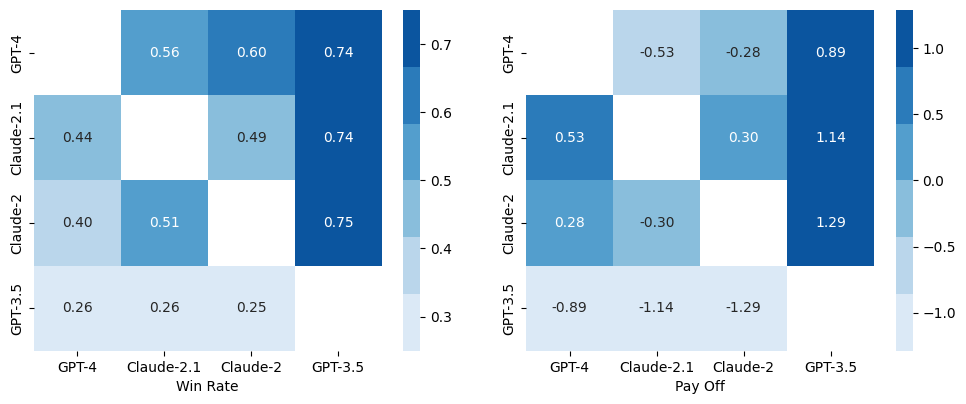

In [14]:
fig, axs = plt.subplots(figsize=(10,4), ncols=2)
fig.tight_layout()

# WIN RATE PLOT
aggregated = from_pandas_to_aggregation(df.copy())

local_aggregate = normalize_win_rate(aggregated.pivot(index="model_1", columns="model_2", values="winrate"))

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)
mask = np.eye(local_aggregate.values.shape[0], dtype=bool)

first_plot = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", cmap=colormap, ax=axs[0])
first_plot.set(ylabel=None)
first_plot.set(xlabel="Win Rate")

# PAYOFF PLOT

local_aggregate = aggregated.pivot(index="model_1", columns="model_2", values="payoff")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)

mask = np.eye(local_aggregate.values.shape[0], dtype=bool)
local_aggregate =local_aggregate.fillna(1)

second_plot = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", cmap=colormap, ax=axs[1])
second_plot.set(ylabel=None)
second_plot.set(xlabel="Pay Off")

plt.savefig('figures/section_one_resource_exchange.pdf', bbox_inches='tight')
plt.show()

In [15]:
!pwd

/home/vinid/projects/negotiation/_notebooks


## Ultimatum

In [6]:
log_dir = "../experiments/section_one/.logs/ultimatum_multi_section_one/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)
df["resource_delta_1"] = df["resource_delta_1"] + 100


2024-01-26 10:40:04.984 
  command:

    streamlit run /Users/patrickjohnchia/Desktop/Projects/negobench/.venv/lib/python3.8/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-01-26 10:40:04.998 No runtime found, using MemoryCacheStorageManager


THERE ARE 240 log files
240 Loaded Successfully


In [62]:
def from_pandas_to_aggregation(new_df):
    df_copy = new_df.copy()
    df_copy = df_copy[df_copy['resource_delta_1']!=100]
    df_copy['models'] = df_copy['model_1'] + '@' + df_copy['model_2']
    
    df_copy['win_1'] = df_copy['resource_delta_1'] > df_copy['resource_delta_2']
    df_copy['win_2'] = df_copy['resource_delta_1'] < df_copy['resource_delta_2']
    df_copy['draw'] = df_copy['resource_delta_1'] == df_copy['resource_delta_2']
    
    df_copy = df_copy.groupby(['game_name', 
                               'models'])[['win_1', 'win_2', 
                                           'resource_delta_1',
                                           'resource_delta_2']].agg(['mean']).reset_index()
    
    df_copy[['model_1', 'model_2']] = df_copy['models'].str.split('@', n=1, expand=True)
    df_copy['win_1'] = df_copy['win_1'] / (df_copy['win_1'] + df_copy['win_2'])
    df_copy['win_2'] = df_copy['win_2'] / (df_copy['win_1'] + df_copy['win_2'])
    
    df_copy.columns = list(map(''.join, ag.columns.values))
    return df_copy


ag = from_pandas_to_aggregation(df.copy())
ag



,game_name,models,win_1mean,win_2mean,resource_delta_1mean,resource_delta_2mean,model_1,model_2
0,MultiTurnUltimatumGame,Claude-2.1@Claude-2,1.000000,0.000000,73.421053,26.578947,Claude-2.1,Claude-2
1,MultiTurnUltimatumGame,Claude-2.1@GPT-3.5,0.900000,0.068966,72.0,28.0,Claude-2.1,GPT-3.5
2,MultiTurnUltimatumGame,Claude-2.1@GPT-4,1.000000,0.000000,61.4,38.6,Claude-2.1,GPT-4
3,MultiTurnUltimatumGame,Claude-2@Claude-2.1,1.000000,0.000000,70.526316,29.473684,Claude-2,Claude-2.1
4,MultiTurnUltimatumGame,Claude-2@GPT-3.5,1.000000,0.000000,75.642857,24.357143,Claude-2,GPT-3.5
5,MultiTurnUltimatumGame,Claude-2@GPT-4,1.000000,0.000000,57.25,42.75,Claude-2,GPT-4
6,MultiTurnUltimatumGame,GPT-3.5@Claude-2,0.666667,0.183673,57.25,42.75,GPT-3.5,Claude-2
7,MultiTurnUltimatumGame,GPT-3.5@Claude-2.1,1.000000,0.000000,70.789474,29.210526,GPT-3.5,Claude-2.1
8,MultiTurnUltimatumGame,GPT-3.5@GPT-4,0.777778,0.113924,60.5,39.5,GPT-3.5,GPT-4
9,MultiTurnUltimatumGame,GPT-4@Claude-2,1.000000,0.000000,60.25,39.75,GPT-4,Claude-2


In [63]:
ag.pivot(index="model_1", columns="model_2", values="win_1mean")



model_2,Claude-2,Claude-2.1,GPT-3.5,GPT-4
model_1,,,,
Claude-2,NaN,1.0,1.000000,1.000000
Claude-2.1,1.000000,NaN,0.900000,1.000000
GPT-3.5,0.666667,1.0,NaN,0.777778
GPT-4,1.000000,1.0,0.909091,NaN


### Win Rate

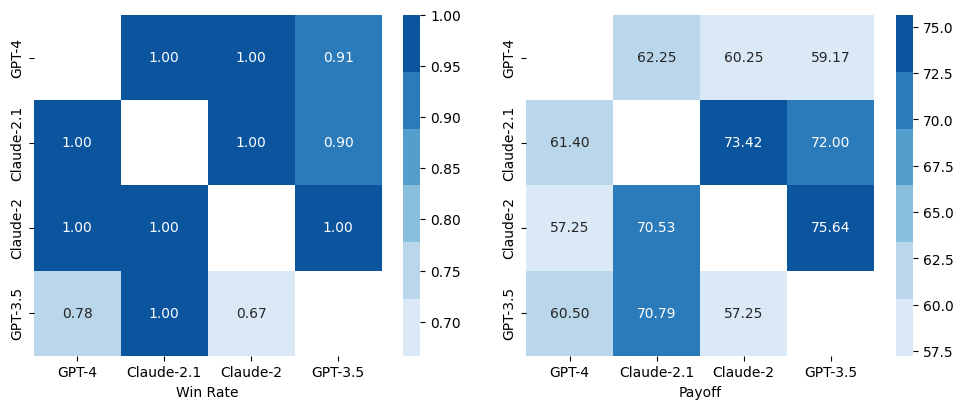

In [65]:
fig, axs = plt.subplots(figsize=(10,4), ncols=2)
fig.tight_layout()
aggregated = from_pandas_to_aggregation(df.copy())

# winrate plot
local_aggregate = aggregated.pivot(index="model_1", columns="model_2", values="win_1mean")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)
mask = np.eye(local_aggregate.values.shape[0], dtype=bool)

first_plot = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", cmap=colormap, ax=axs[0])
first_plot.set(ylabel=None)
first_plot.set(xlabel="Win Rate")

# Payoff plot
local_aggregate = aggregated.pivot(index="model_1", columns="model_2", values="resource_delta_1mean")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)

mask = np.eye(local_aggregate.values.shape[0], dtype=bool)
local_aggregate =local_aggregate.fillna(1)

second_plot = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", cmap=colormap, ax=axs[1])
second_plot.set(ylabel=None)
second_plot.set(xlabel="Payoff")

# plt.savefig('figures/section_one_ultimatum.pdf', bbox_inches='tight')
plt.show()

# Seller and Buyer

In [9]:
log_dir = "../experiments/section_one/.logs/buysell_section_one/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
temp_df = compute_game_summary(game_states)

2024-01-24 16:35:40.086 
  command:

    streamlit run /home/vinid/.local/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-01-24 16:35:40.087 No runtime found, using MemoryCacheStorageManager


THERE ARE 384 log files
384 Loaded Successfully


In [10]:
df = replace_names(temp_df.copy())

df["vals1"] = df["vals1"].apply(lambda x : x.valuation_dict["X"])
df["vals2"] = df["vals2"].apply(lambda x : x.valuation_dict["X"])

### BuySell Payoffs

For each model, we want to extract the payoff against the other players

In [14]:
gb = df.groupby('vals1')    
seller_at_40, seller_at_60 = [gb.get_group(x).copy() for x in gb.groups]

In [15]:
assert seller_at_40.iloc[0]["vals1"] == 40

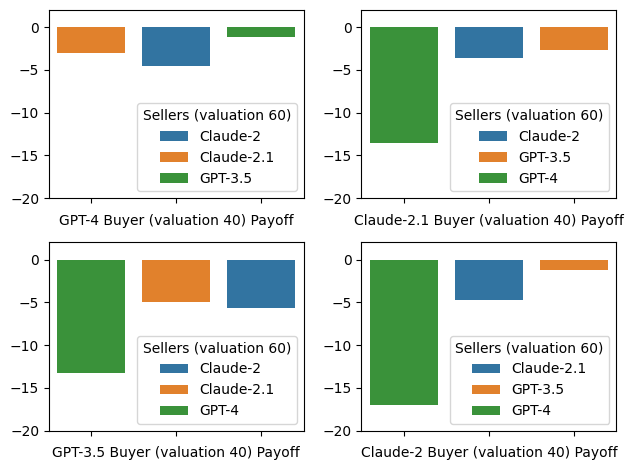

<Figure size 1000x2000 with 0 Axes>

In [9]:
fig, axs = plt.subplots(2,2)
plt.figure(figsize=(10,20))
fig.tight_layout()

for local_agent_plot, locs in zip(AGENTS_CLEAN_NAMES, [axs[0,0], axs[0,1], axs[1,1], axs[1,0]]):
    
    aggregated = seller_at_60.groupby(["model_1", "model_2"])[['outcome_1', 'outcome_2',
       'resource_delta_1', 'resource_delta_2']].mean().reset_index().copy()
    
    aggregated = aggregated[aggregated["model_2"].isin([local_agent_plot])]

    # names to plot things
    local_copy_of_agents = AGENTS_CLEAN_NAMES[:]
    local_copy_of_agents.remove(local_agent_plot)
    
    figu = sns.barplot(aggregated, x="model_1", y="outcome_2", order=local_copy_of_agents,
                       hue="model_1", dodge=False, ax=locs)
    
    figu.legend(title=f'Sellers (valuation 60)', loc='lower right')
    
    figu.set(ylabel=None)
    figu.set_ylim(-20, 2)
    figu.set(xlabel=f"{local_agent_plot} Buyer (valuation 40) Payoff")
    figu.set_xticklabels(labels=[])

fig.get_figure().savefig('figures/section_one_seller_at_60.pdf', bbox_inches='tight')
plt.show()

In [16]:
sns.set_context("poster")

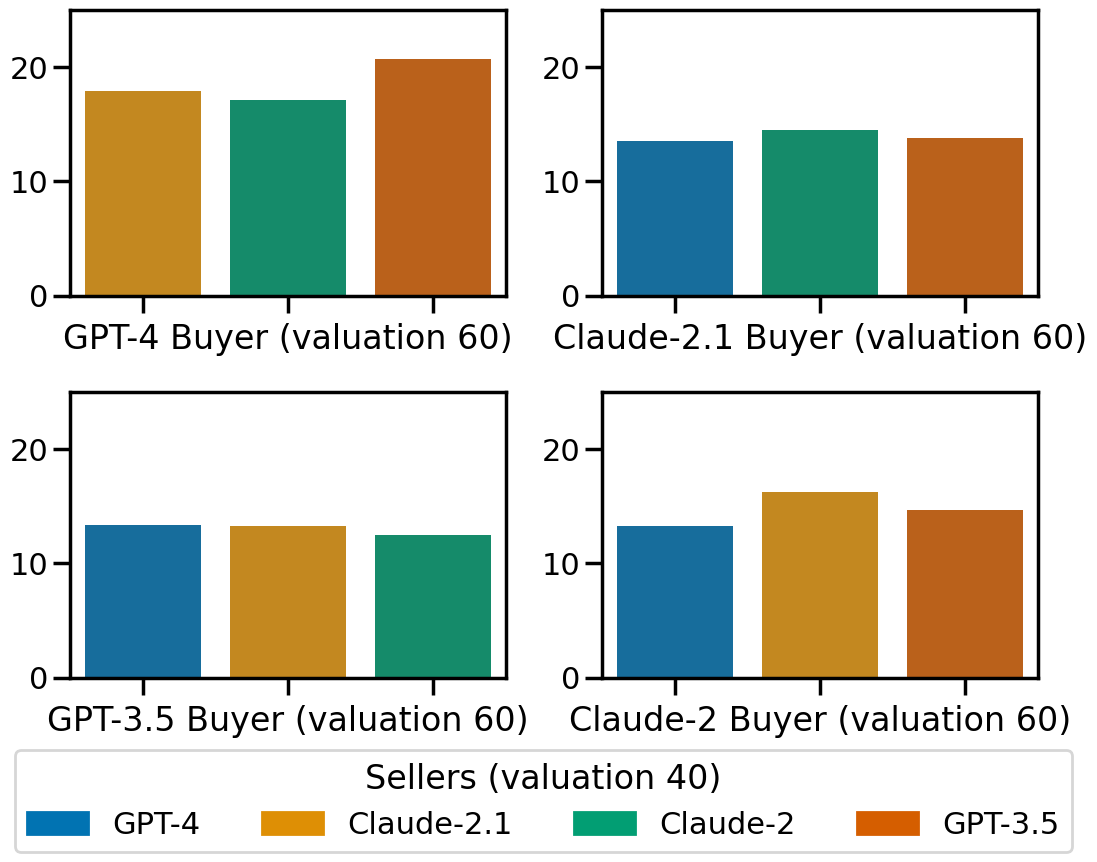

In [86]:
fig, axs = plt.subplots(2,2, figsize=(11,8))
fig.tight_layout()
sns.set_palette("colorblind")

unique = ['GPT-4', 'Claude-2.1', 'Claude-2', 'GPT-3.5']


palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))

for local_agent_plot, locs in zip(AGENTS_CLEAN_NAMES, [axs[0,0], axs[0,1], axs[1,1], axs[1,0]]):
    
    aggregated = seller_at_40.groupby(["model_1", "model_2"])[['outcome_1', 'outcome_2',
       'resource_delta_1', 'resource_delta_2']].mean().reset_index().copy()
    
    aggregated = aggregated[aggregated["model_2"].isin([local_agent_plot])]

    # names to plot things
    local_copy_of_agents = AGENTS_CLEAN_NAMES[:]
    local_copy_of_agents.remove(local_agent_plot)
    
    figu = sns.barplot(aggregated, x="model_1", y="outcome_2", order=local_copy_of_agents,
                       hue="model_1", dodge=False, ax=locs, palette=palette)
    figu.legend_.remove()
    #figu.legend(title=f'Sellers (valuation 40)', loc='upper right')
    
    figu.set(ylabel=None)
    figu.set_ylim(0, 25)
    figu.set(xlabel=f"{local_agent_plot} Buyer (valuation 60)")
    figu.set_xticklabels(labels=[])

#handles, labels = axs[-1][-1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center')
custom_lines = [
    mpatches.RegularPolygon((0, 0), 5, radius=0.1, color=p) for p in list(palette.values())]
      
from matplotlib.lines import Line2D
fig.tight_layout()
# custom_lines = [
#     #mpatches.RegularPolygon((0, 0), 5, radius=0.1),
#     Line2D([0], [0], color=p, lw=10) for p in list(palette.values())]



axs[1,1].legend(custom_lines, palette.keys(), ncol=4, loc='upper center', bbox_to_anchor=(-0.135, -0.20), title=f'Sellers (valuation 40)')


# Add a new legend to the first subplot with horizontal layout
#axs[0].legend(handles, labels, ncol=len(handles), loc='upper center', bbox_to_anchor=(0.5, -0.05))

fig.get_figure().savefig('figures/section_one_seller_at_40.pdf', bbox_inches='tight')
plt.show()